In [1]:
import sys
sys.path.append('/data/rradev/generator_reweight/')

# EOS being weird
!kinit rradev@CERN.CH -k -t rradev.keytab

kinit: Pre-authentication failed: Invalid argument while getting initial credentials


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import latex
import numpy as np
import seaborn as sns
import argparse


from sklearn.metrics import classification_report
from src.utils.plotting import plot_distribution
from src.utils.funcs import calculate_weights

In [ ]:
_

In [3]:
reweighted_samples_path = '/data/rradev/generator_reweight/reweighted_samples/'
col_names =  ["isNu", "isNue", "isNumu", "isNutau", "cc", "Enu_true", "ELep", "CosLep", "Q2", "W", "x", "y", "nP", "nN", "nipip", "nipim", "nipi0", "niem", "eP", "eN", "ePip", "ePim", "ePi0"]

def load_feats_logits(generator_a, generator_b):
    column_names = col_names.copy().tolist()
    column_names.append('labels')
    column_names.append('logits')
    
    data = np.load(reweighted_samples_path + f'{generator_a}_to_{generator_b}.npy')
    return pd.DataFrame(data=data, columns=column_names)

def load_weights(generator_name):
    return np.load('/data/rradev/generator_reweight/reweighted_samples/GiBUU_GiBUU_weights.npy')

In [4]:
manyBins = 100
vars_meta = np.array(
             [["isNu", 2, 0, 1, r"$\nu / \bar{\nu}$ flag"],
              ["isNue", 2, 0, 1, r"$\nu_{e}$ flag"],
              ["isNumu", 2, 0, 1, r"$\nu_{\mu}$ flag"],
              ["isNutau", 2, 0, 1, r"$\nu_{\tau}$ flag"],
              ["cc", 2, 0, 1, "CC flag"],
              ["Enu_true", manyBins, 0, 10, "Neutrino energy [GeV]"],
              ["ELep", manyBins, 0, 5, "Lepton energy [GeV]"],
              ["CosLep", manyBins, -1, 1, r"cos$\theta_{\ell}$"],
              ["Q2", manyBins, 0, 10, r"Q^2"],
              ["W", manyBins, 0, 5, r"W [GeV/$c^{2}$]"],
              ["x", manyBins, 0, 1, "x"],
              ["y", manyBins, 0, 1, "y"],
              ["nP", 15, 0, 15, "Number of protons"],
              ["nN", 15, 0, 15, "Number of neutrons"],
              ["nipip", 10, 0, 10, r"Number of $\pi^{+}$"],
              ["nipim", 10, 0, 10, r"Number of $\pi^{-}$"],
              ["nipi0", 10, 0, 10, r"Number of $\pi^{0}$"],
              ["niem", 10, 0, 10, r"Number of EM objects"],
              ["eP", manyBins-1, 1./manyBins , 5, "Total proton kinetic energy"],
              ["eN", manyBins-1, 1./manyBins, 5, "Total neutron kinetic energy"],
              ["ePip", manyBins-1, 1./manyBins, 5, r"Total $\pi^{+}$ kinetic energy"],
              ["ePim", manyBins-1, 1./manyBins, 5, r"Total $\pi^{-}$ kinetic energy"],
              ["ePi0", manyBins-1, 1./manyBins, 5, r"Total $\pi^{0}$ kinetic energy"]]).transpose()

col_names, n_bins, x_min, x_max, fig_title = vars_meta

In [20]:
generator_a = 'GENIEv2'
generator_b = 'GENIEv3_G18_10b'

dataf = load_feats_logits(generator_a, generator_b)
genie, other = dataf[dataf['labels'] == 0], dataf[dataf['labels'] == 1]

genie['weights'], genie['probas'] = calculate_weights(genie['logits'], weight_cap=4, nominal_is_zero=False)
other['weights'], other['probas'] = calculate_weights(other['logits'], weight_cap=4, nominal_is_zero=False)

Nominal generator is not with zero label
Nominal generator is not with zero label


/tmp/rradev/ipykernel_32306/1478704402.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genie['weights'], genie['probas'] = calculate_weights(genie['logits'], weight_cap =4, nominal_is_zero=False)
/tmp/rradev/ipykernel_32306/1478704402.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other['weights'], other['probas'] = calculate_weights(other['logits'], weight_cap=4, nominal_is_zero=False)


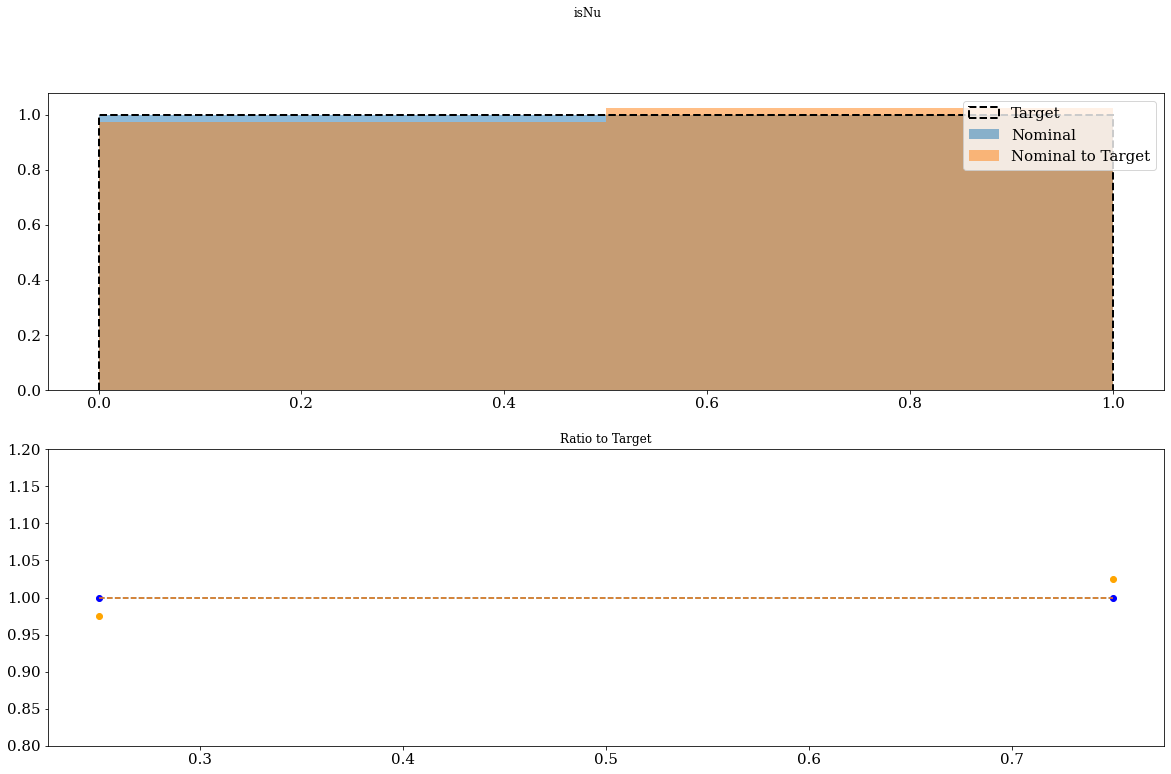

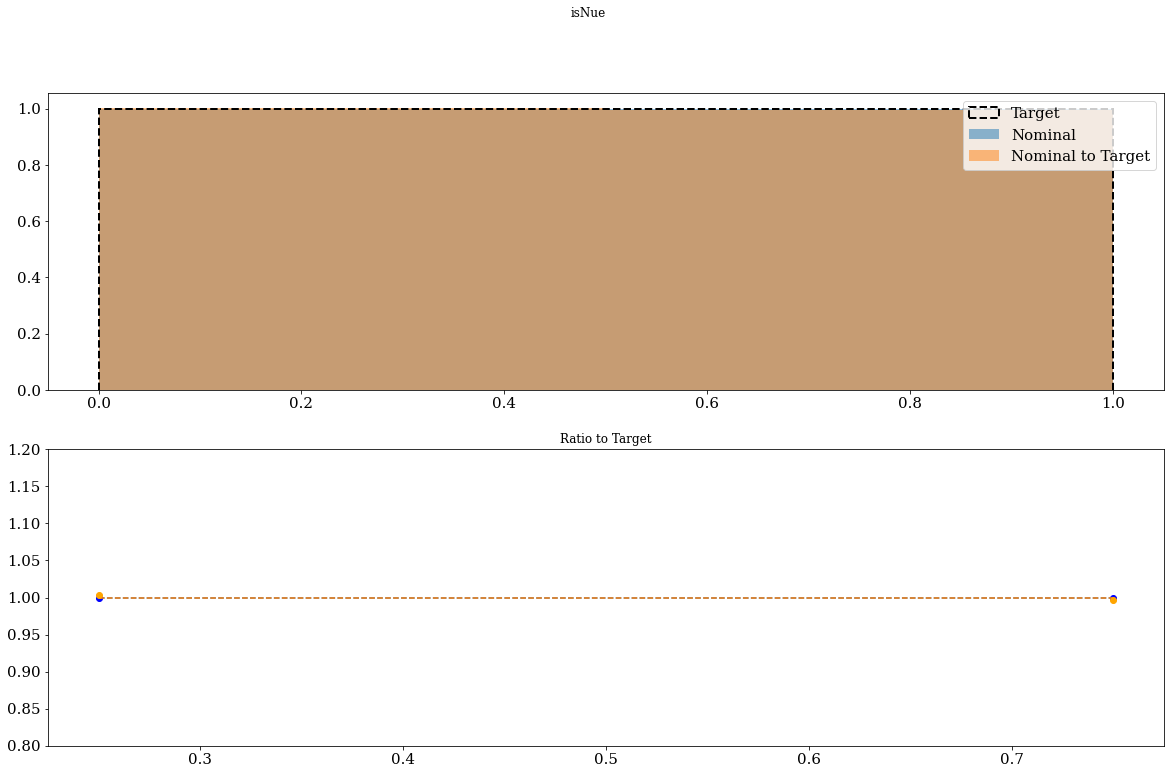

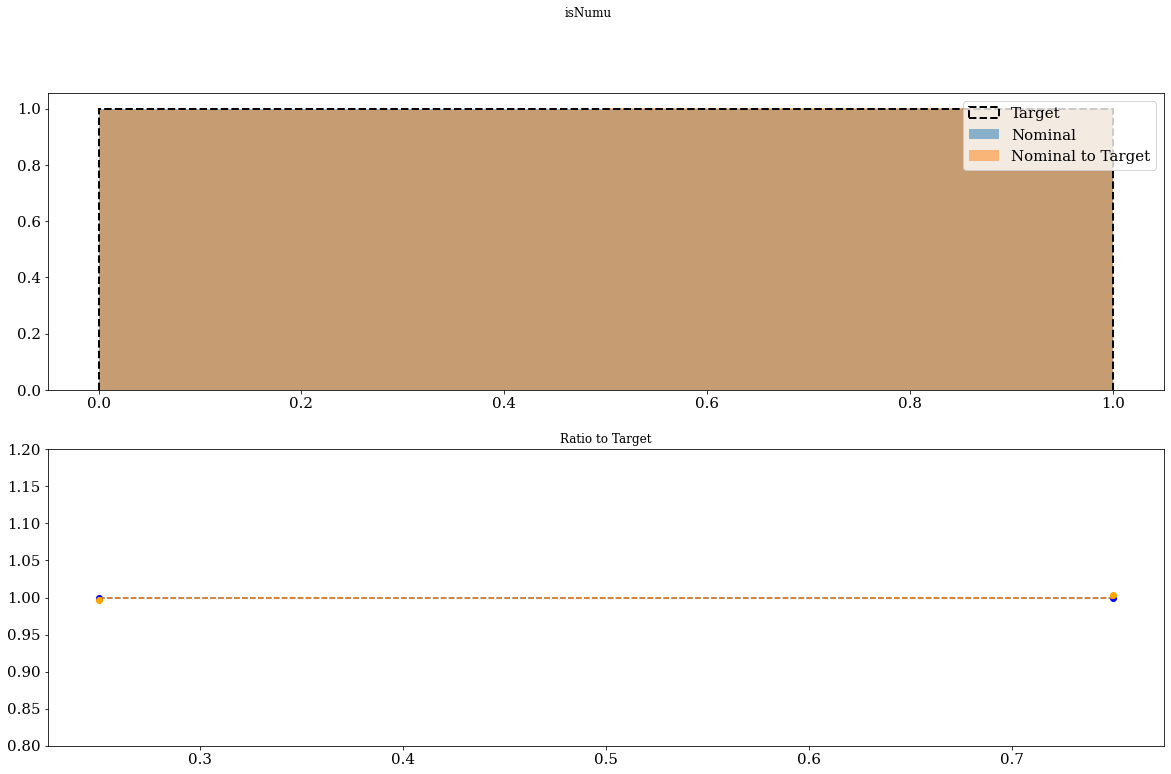

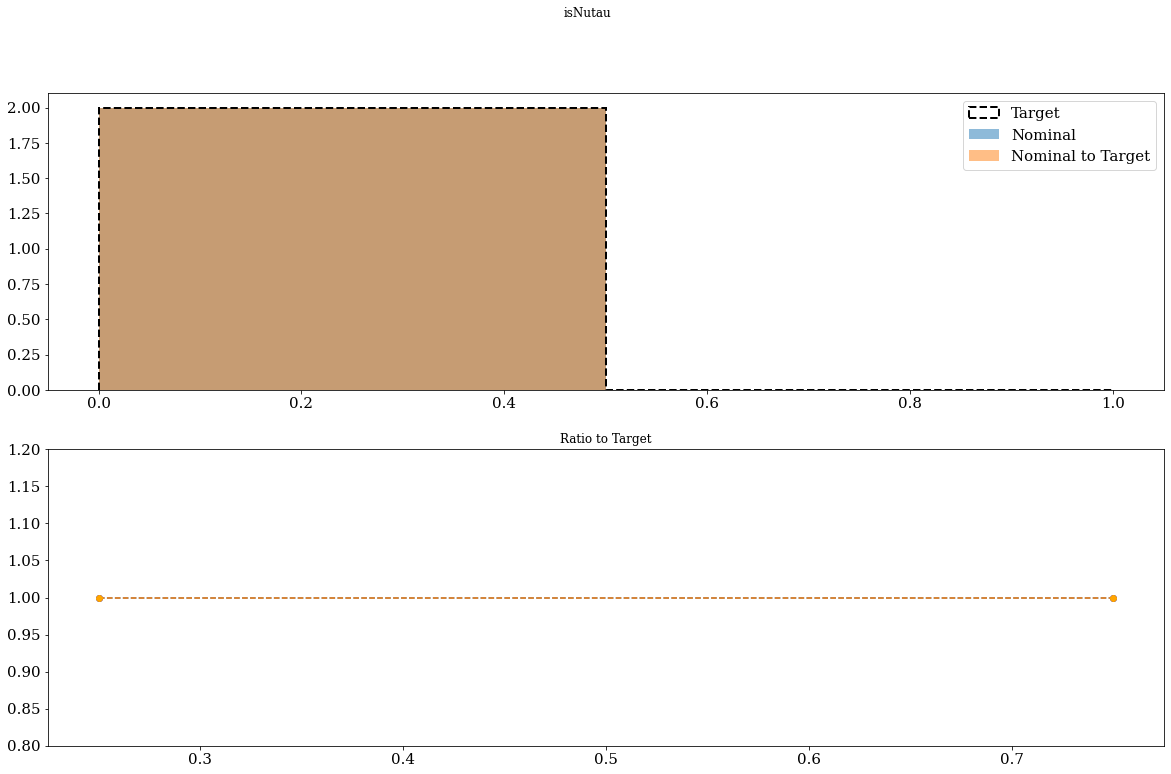

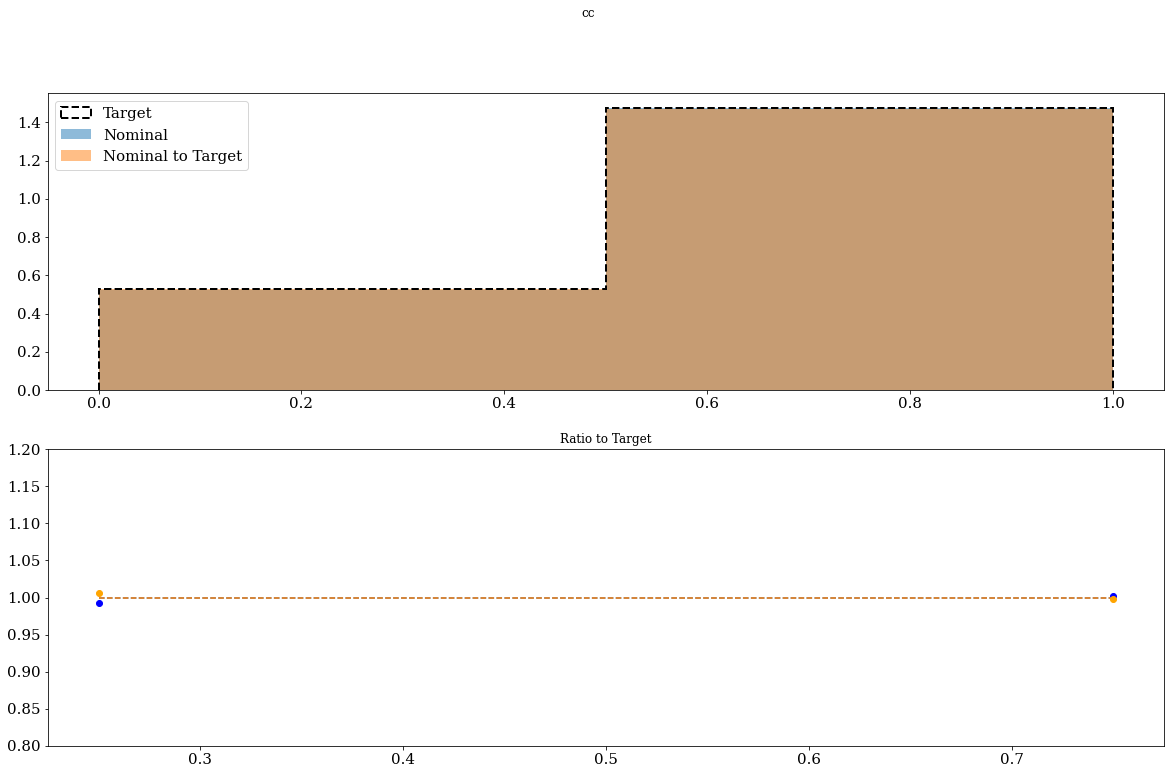

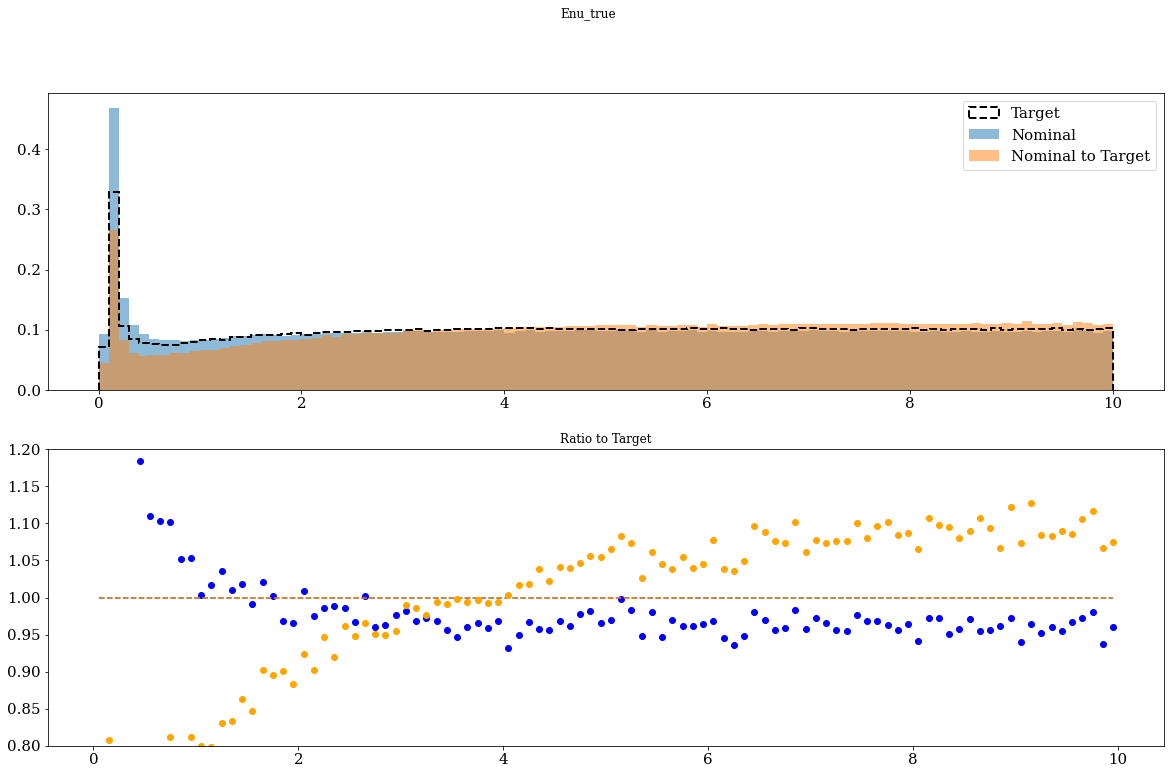

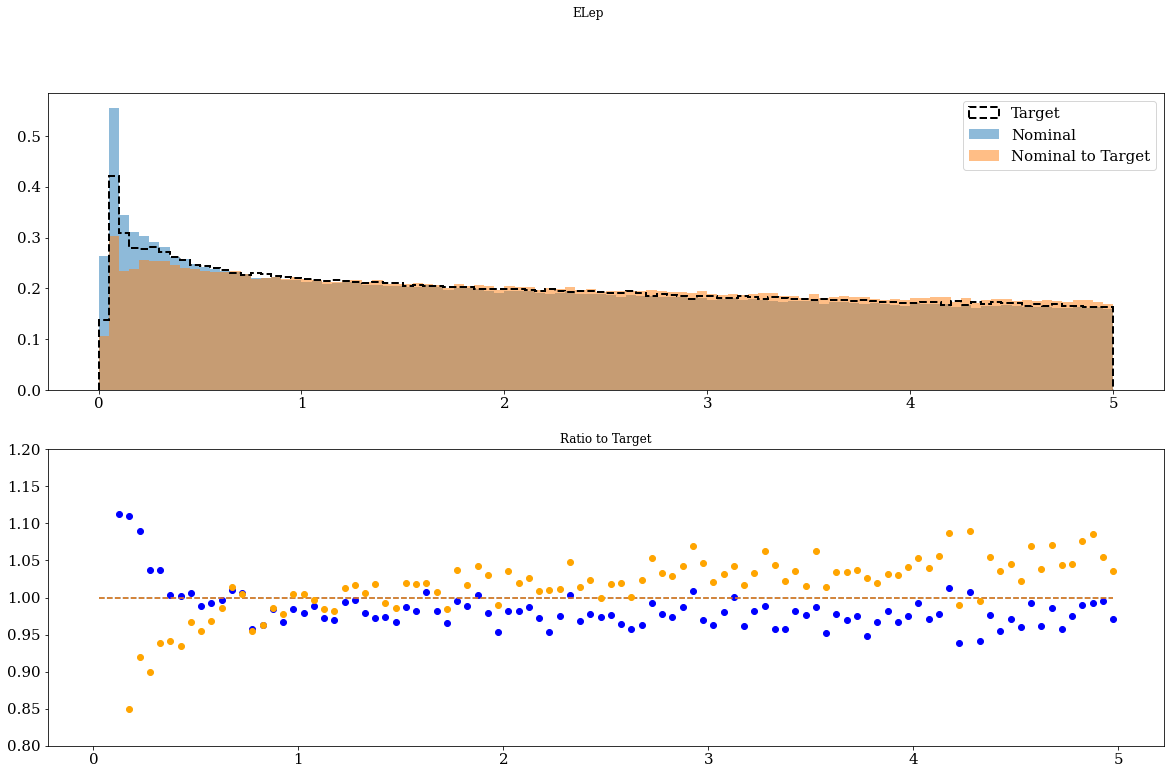

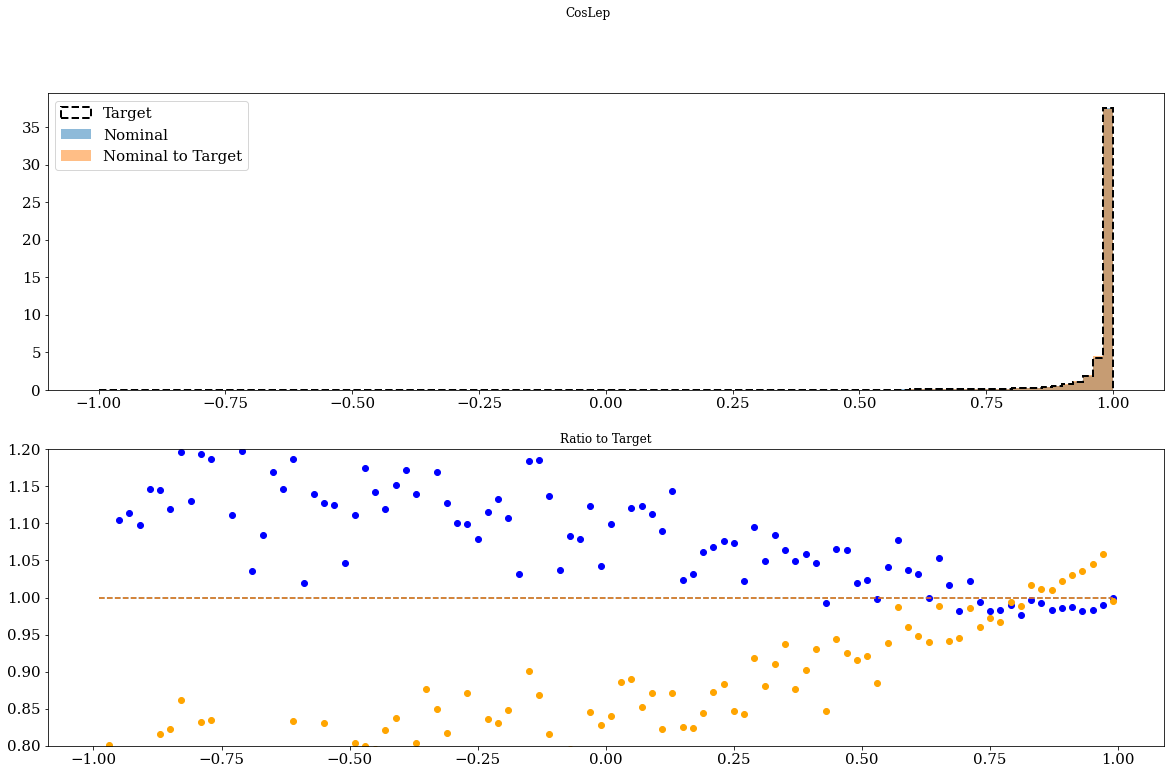

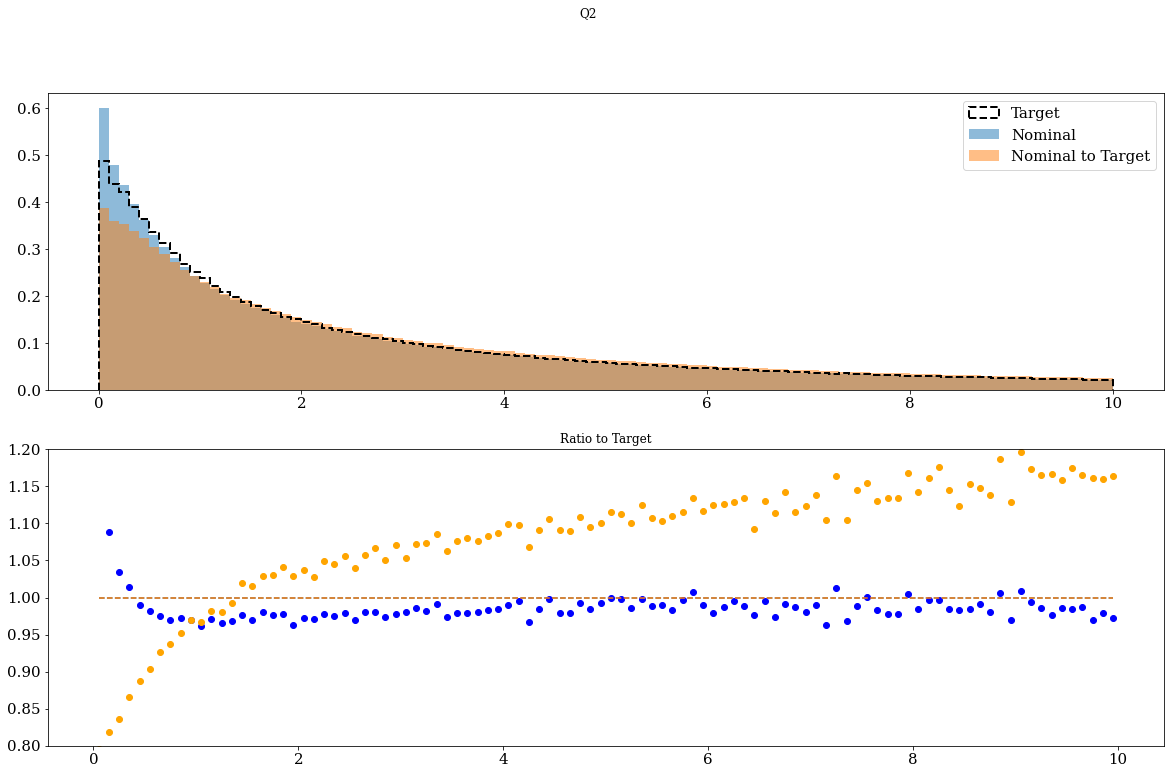

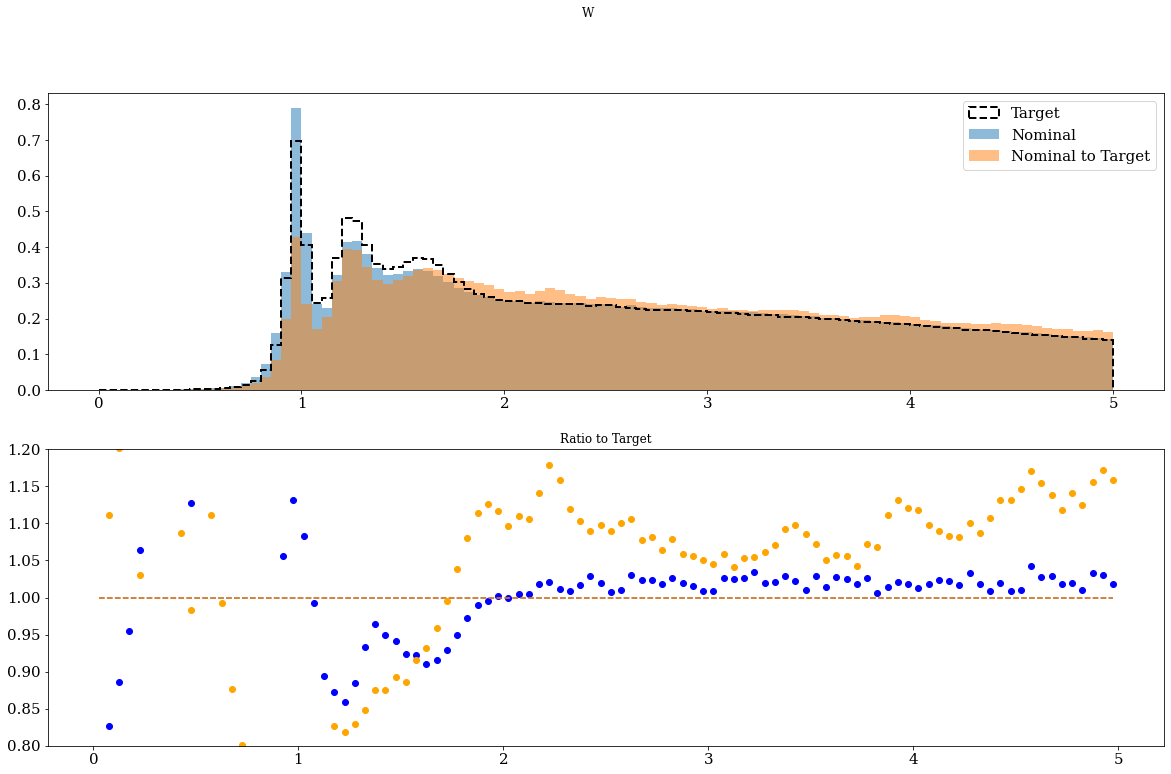

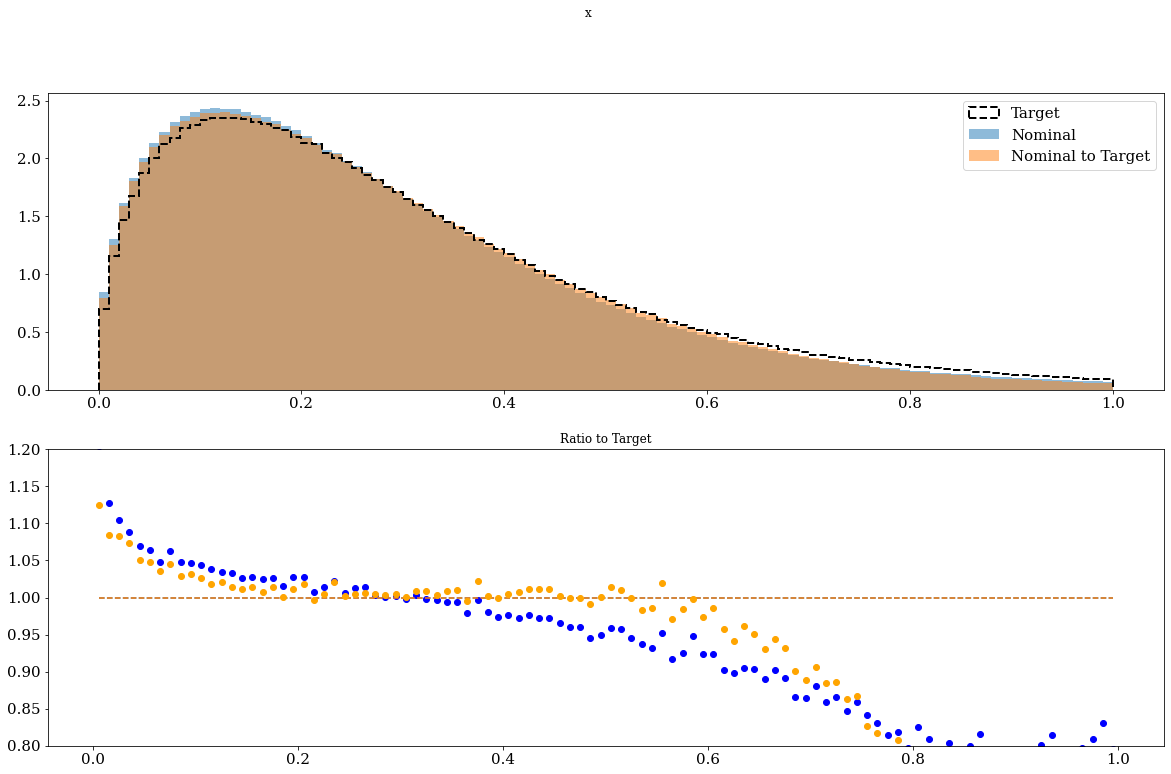

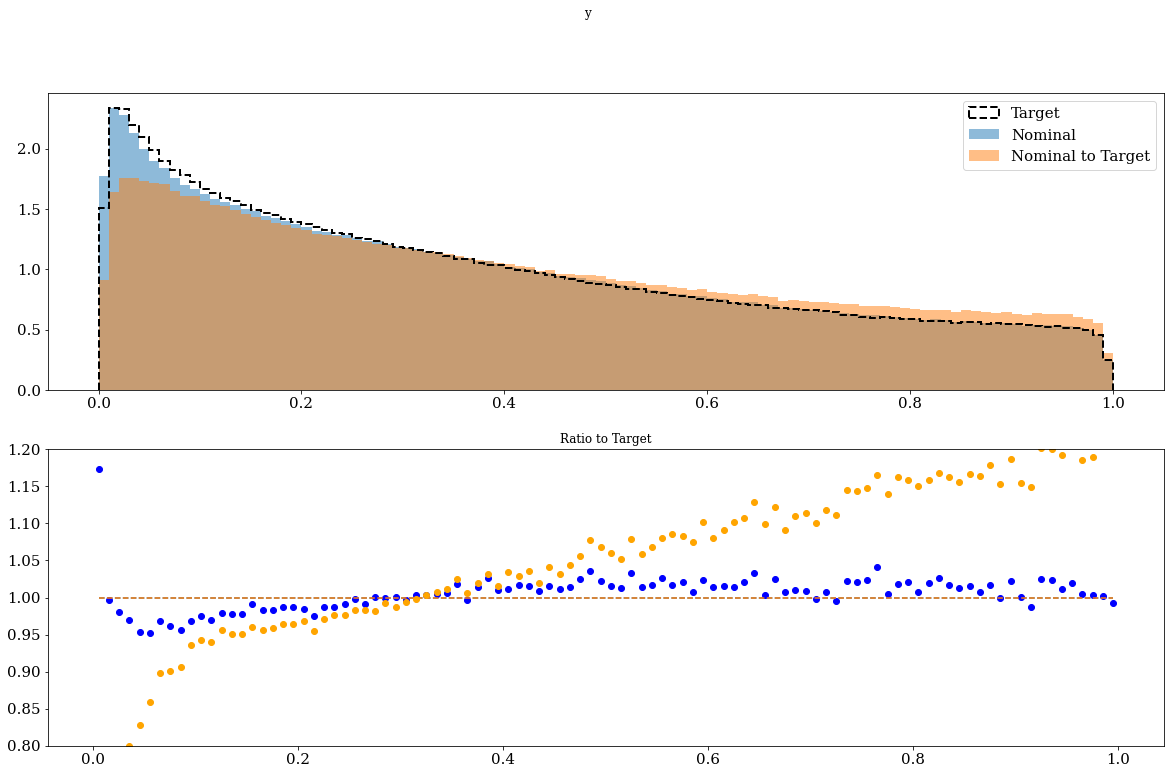

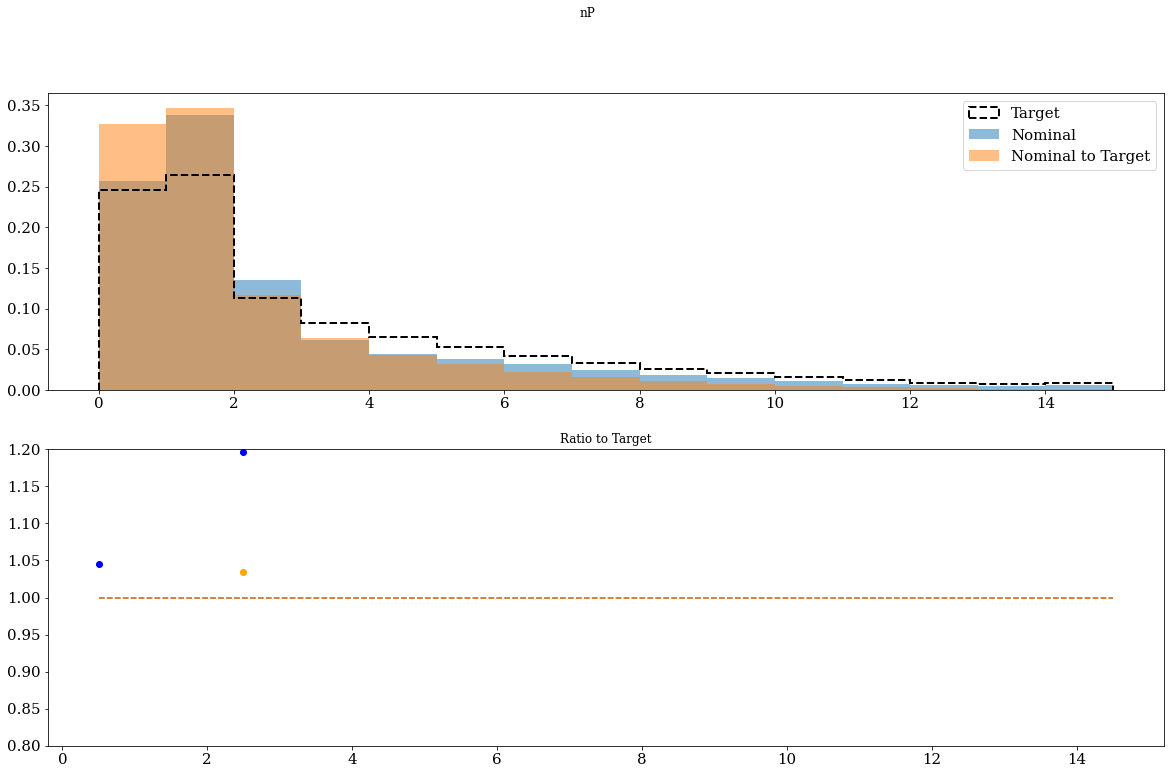

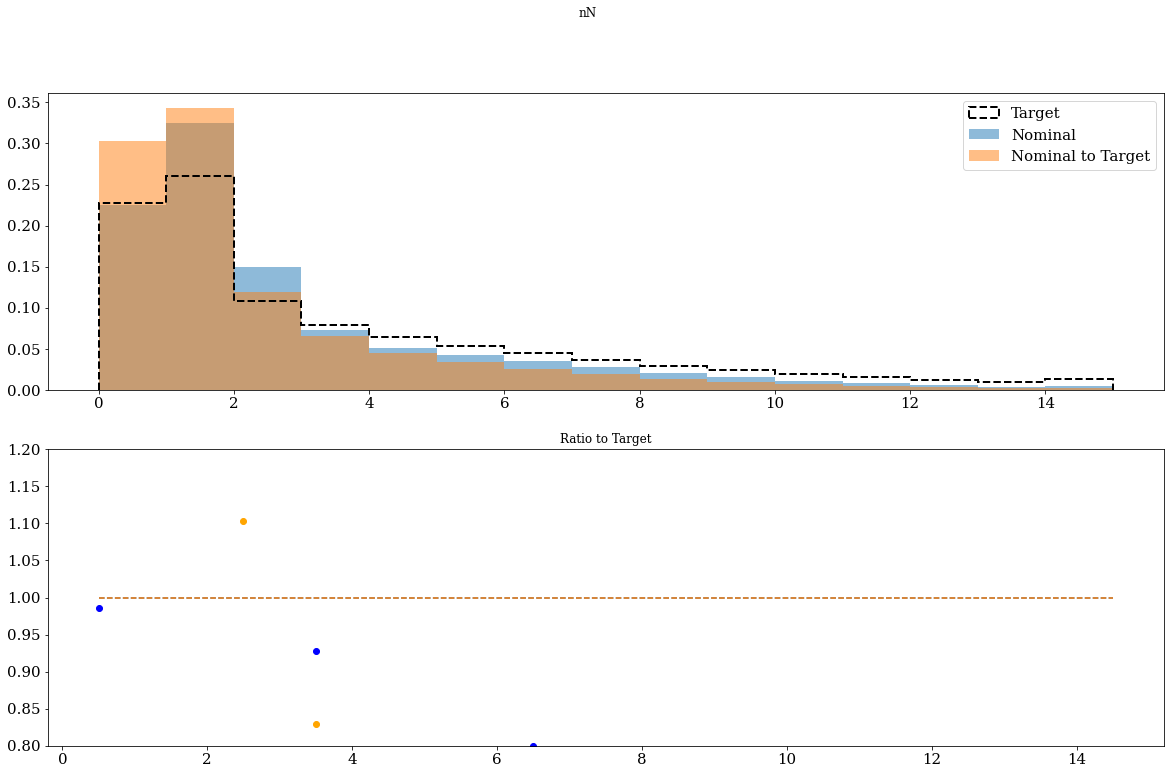

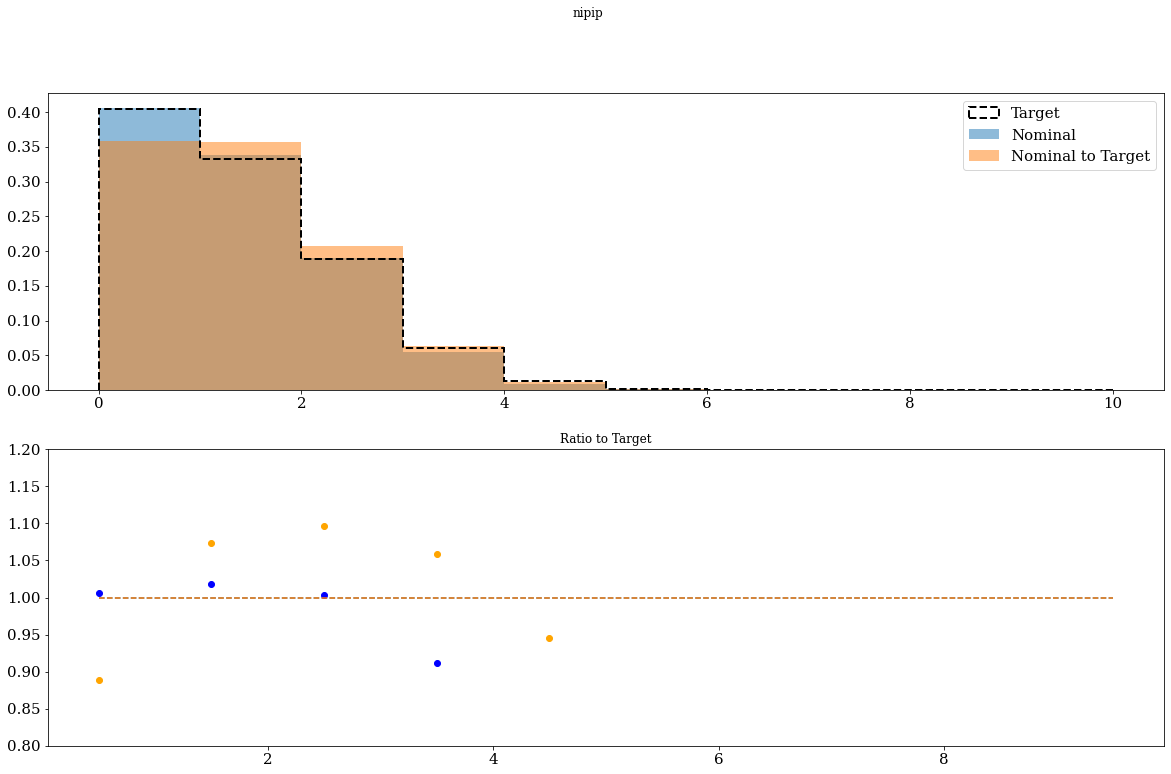

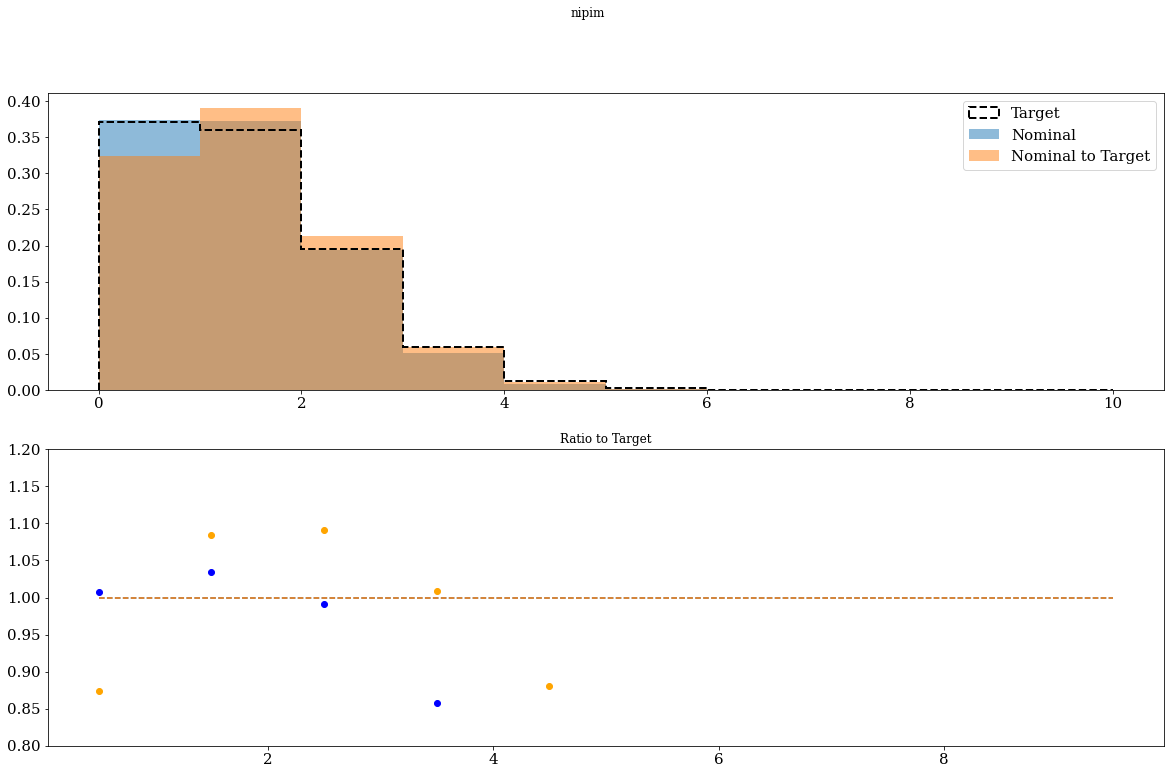

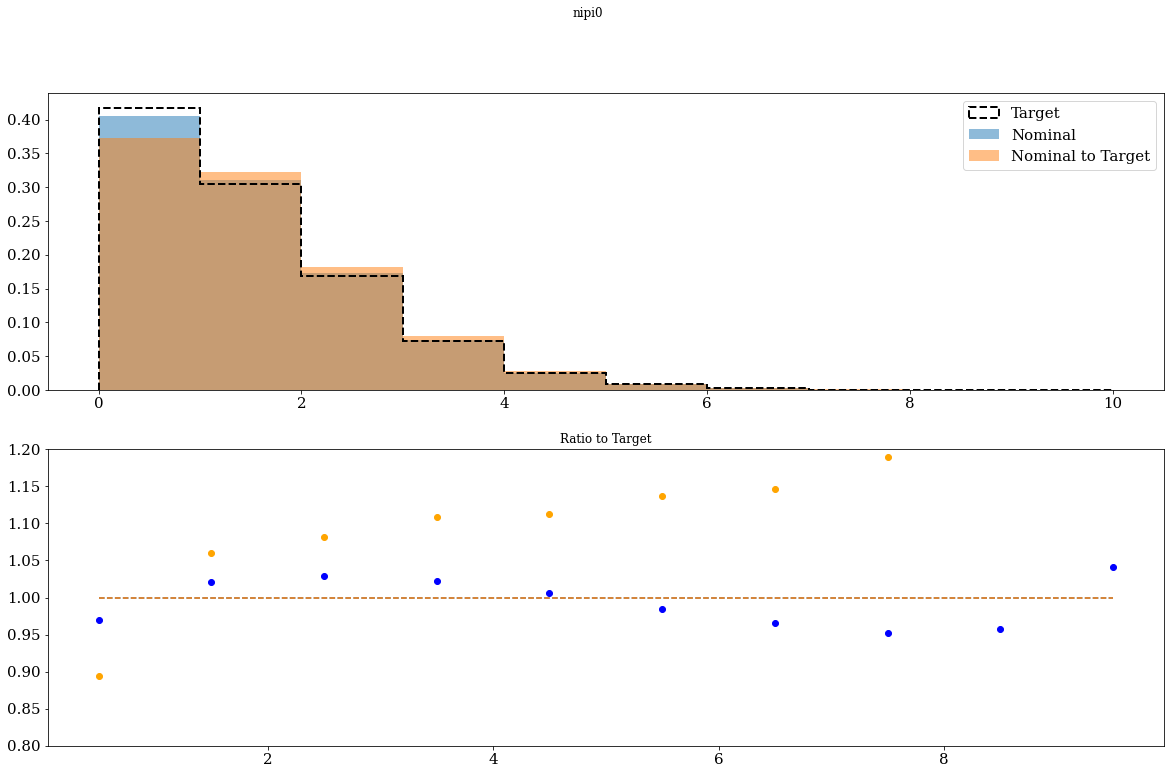

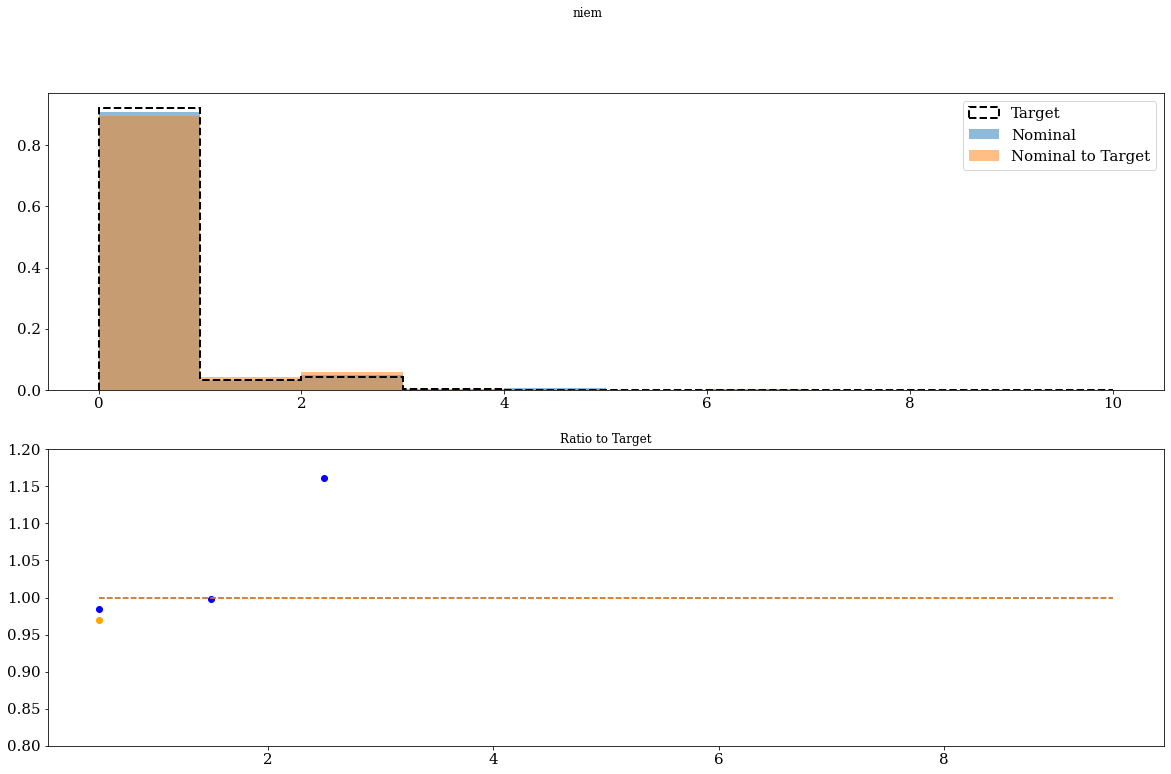

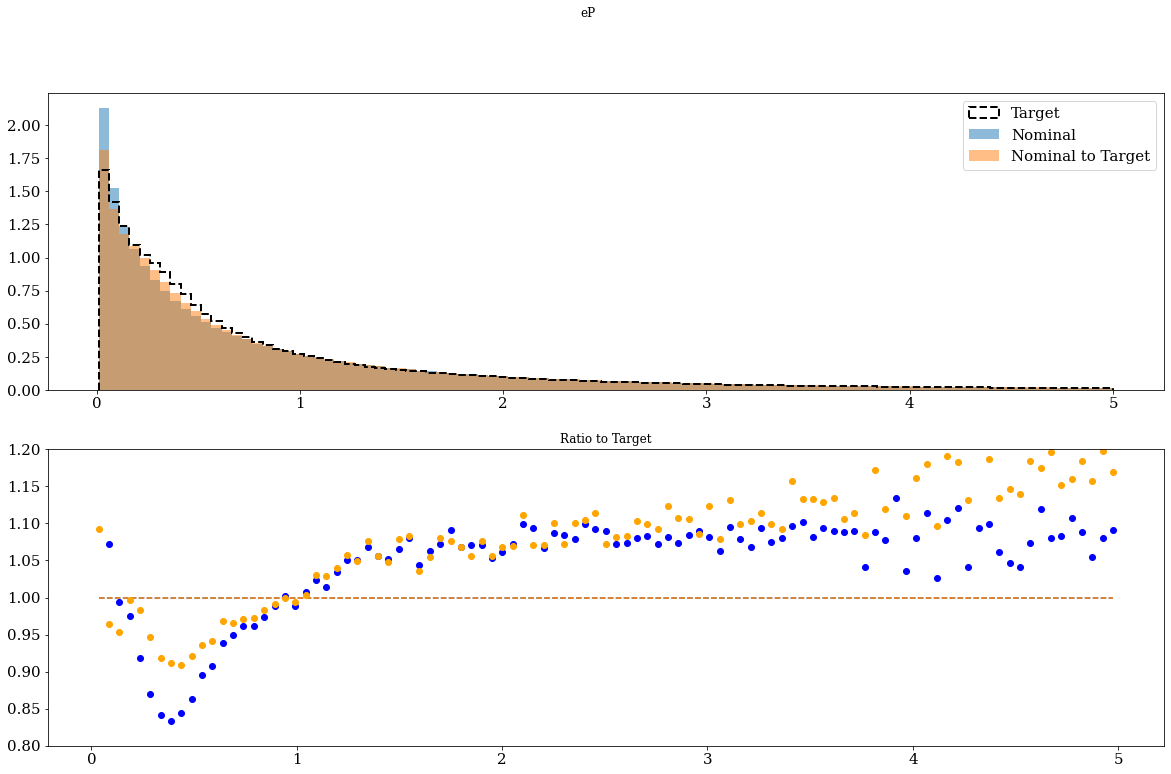

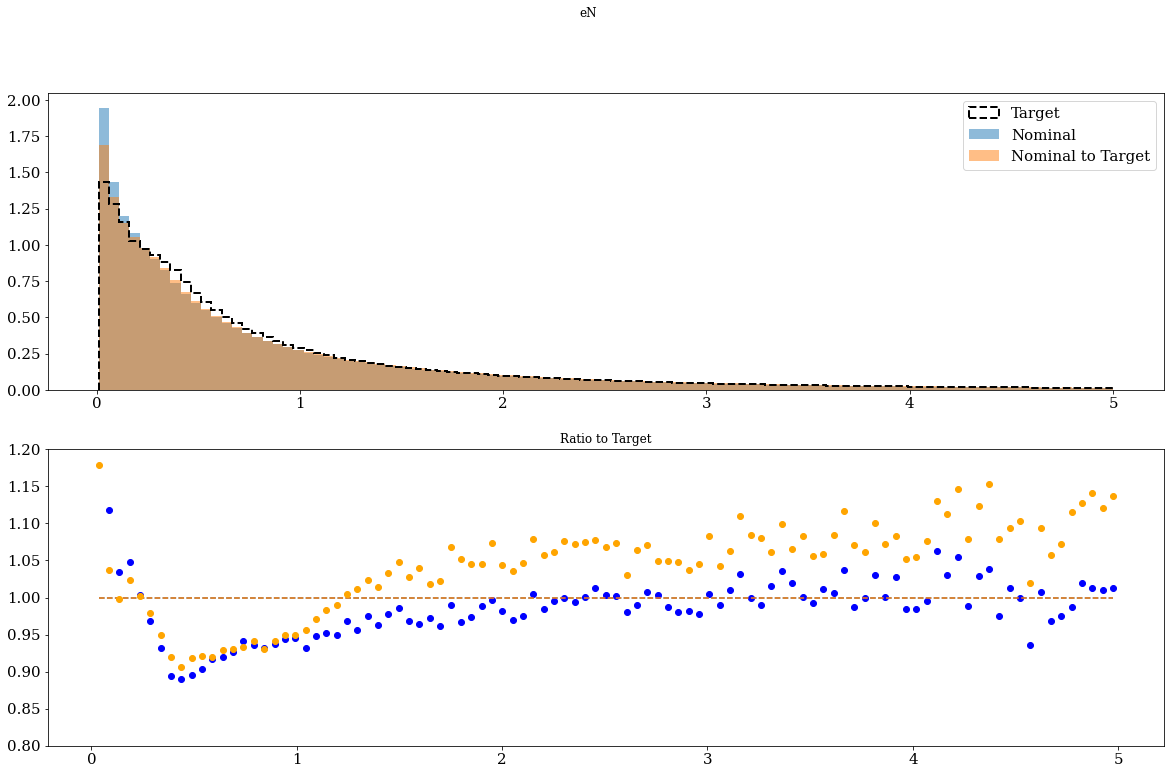

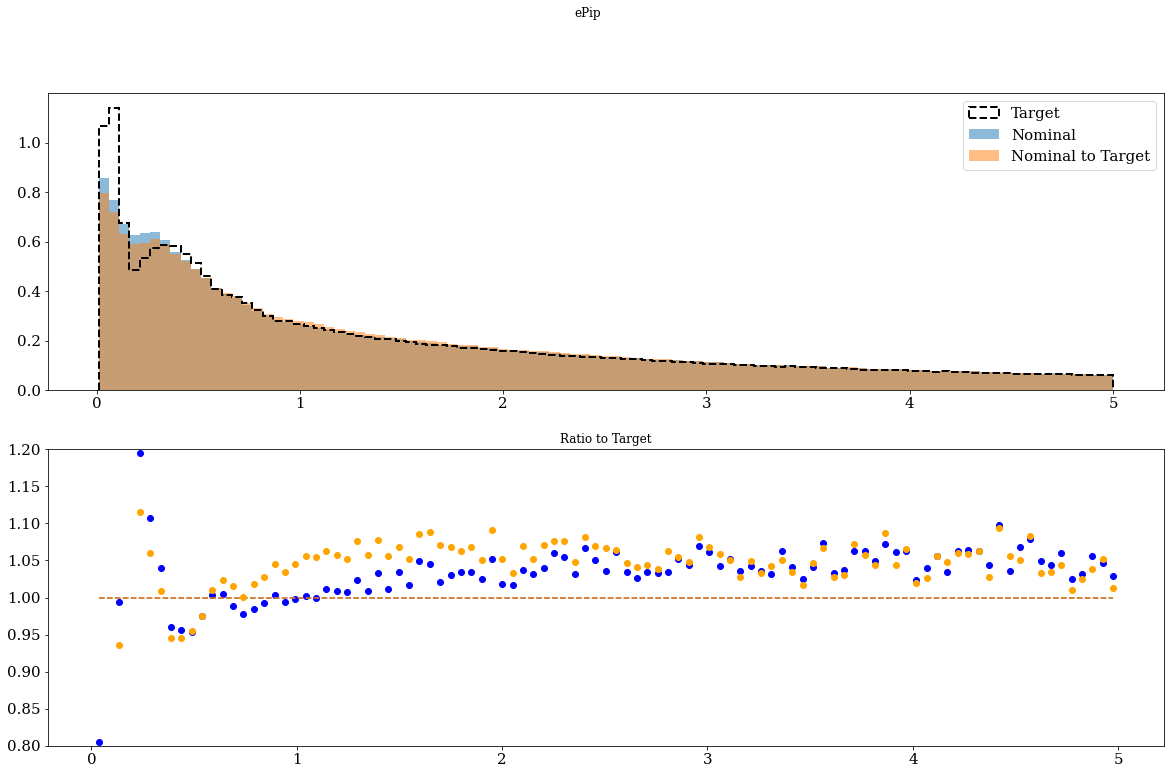

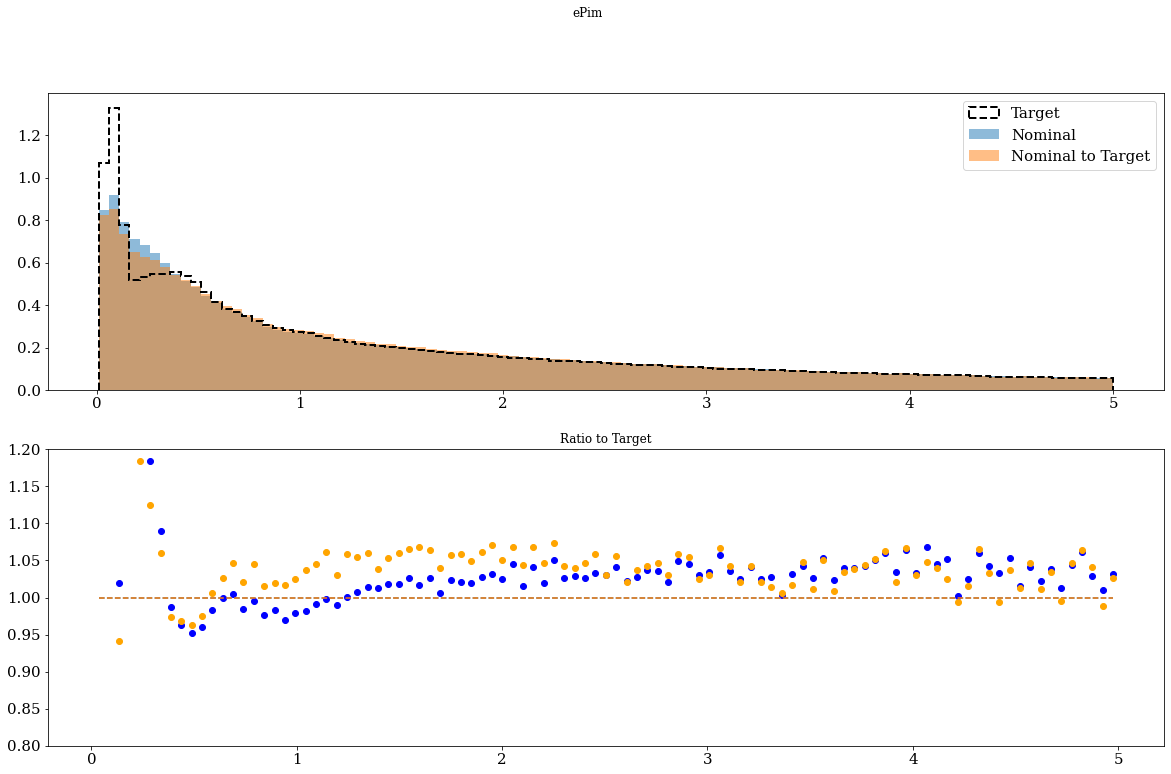

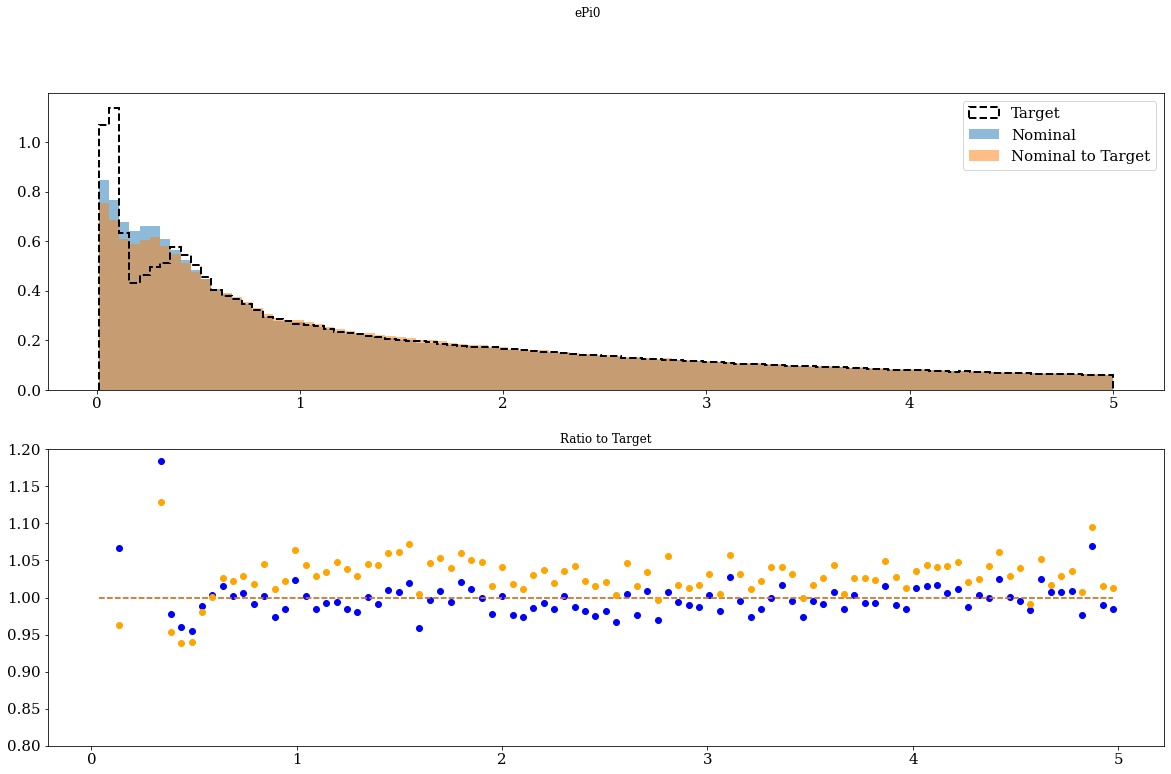

In [21]:
# Loop through columns and plot
plt.rcParams['figure.figsize'] = (20, 12)
for idx, variable in enumerate(col_names):
    hist_range = (float(x_min[idx]), float(x_max[idx]))

    plot_distribution(genie[variable], 
                      other[variable], 
                      genie['weights'],
                      n_bins=int(n_bins[idx]), 
                      errorbars=False, 
                      density=True, 
                      range=hist_range,
                      ratio_limits = (0.8, 1.2))
    plt.suptitle(variable)
    plt.show()

In [7]:
len(other)/(len(genie))

1.0

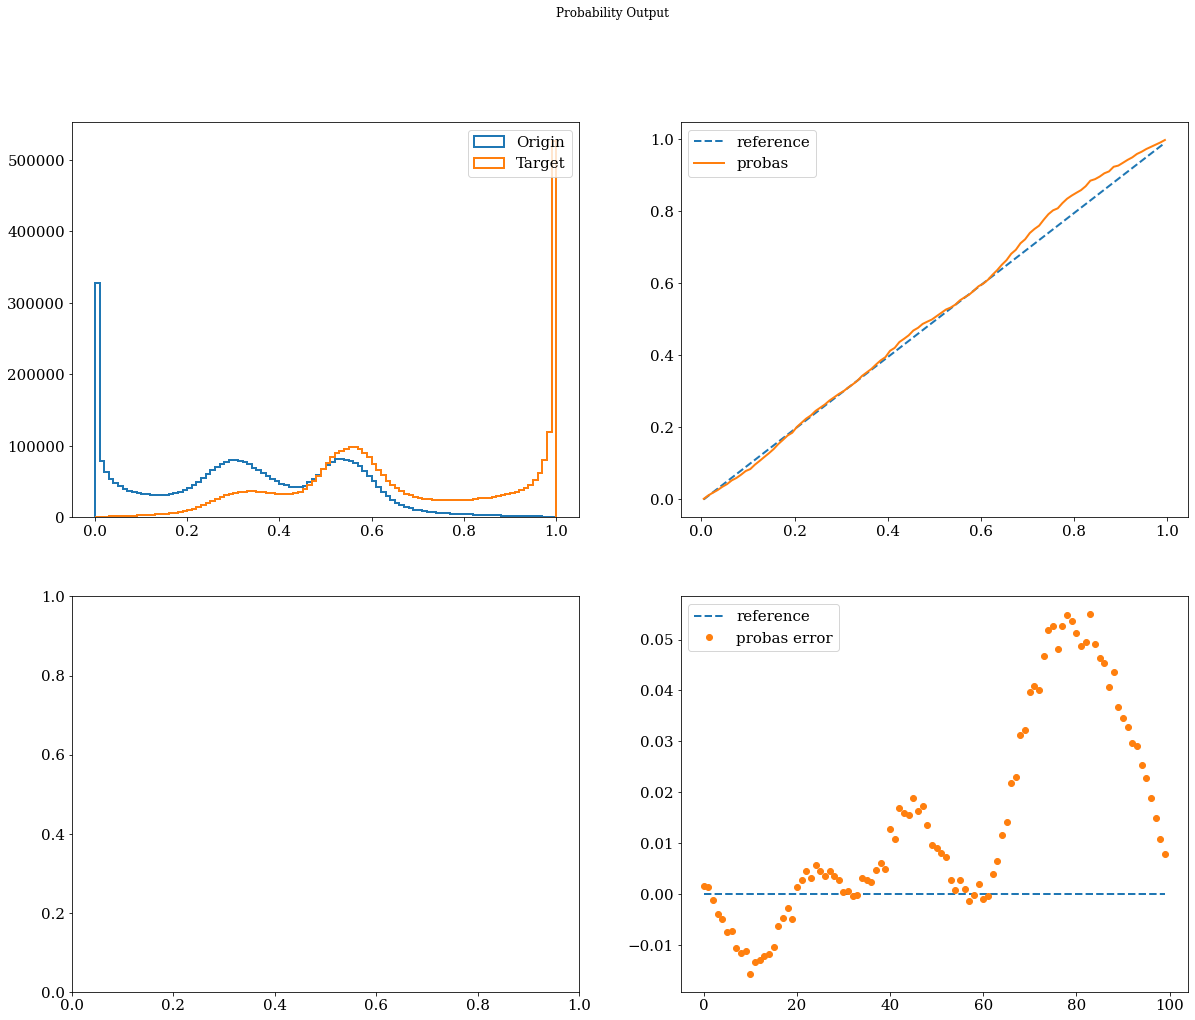

In [18]:
plt.rcParams['figure.figsize'] = (20, 16)
from src.utils.plotting import probability_plots

probability_plots(genie['probas'], other['probas'])

In [9]:
def add_preds(df, true_label=1):
    df['pred'] = (df['probas'] > 0.5).astype(int)
    df['label'] = true_label
    return df

def print_classification_report(genie, other):
    df = pd.concat([genie, other])
    clf_report = classification_report(
        y_true=df['label'],
        y_pred=df['pred'])
    print(clf_report)

genie = add_preds(genie, true_label=0)
other = add_preds(other, true_label=1)

print_classification_report(genie, other)

/tmp/rradev/ipykernel_32306/177504629.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = (df['probas'] > 0.5).astype(int)
/tmp/rradev/ipykernel_32306/177504629.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = true_label


              precision    recall  f1-score   support

           0       0.73      0.72      0.72   4000000
           1       0.72      0.73      0.73   4000000

    accuracy                           0.73   8000000
   macro avg       0.73      0.73      0.73   8000000
weighted avg       0.73      0.73      0.73   8000000



(0.0, 1651979.7)

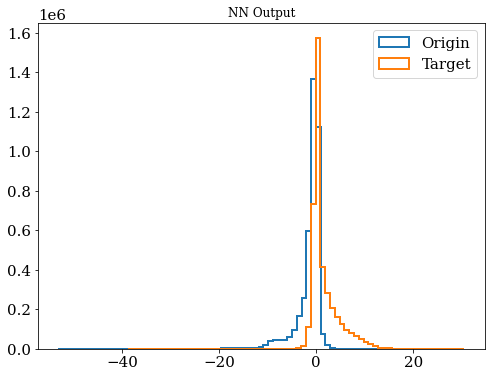

In [10]:
plt.rcParams['figure.figsize'] = (8, 6)
plt.hist(np.array(genie['logits']), bins=70, histtype="step", label='Origin', linewidth=2)
plt.hist(np.array(other['logits']), bins=70, histtype="step", label='Target', linewidth=2)
plt.legend()
plt.title('NN Output')
plt.ylim()

Text(0.5, 1.0, 'Distribution of Weights')

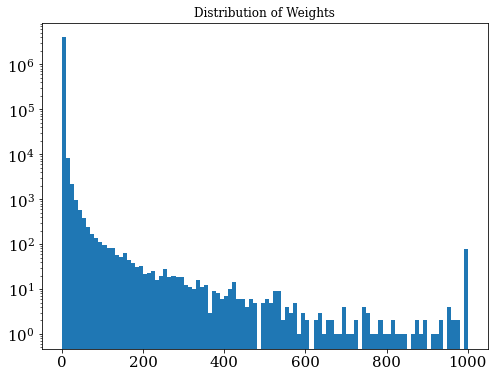

In [11]:
plt.hist(genie['weights'], bins=100)
plt.yscale('log')
plt.title('Distribution of Weights')